In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, Bidirectional, Dropout

import matplotlib.pyplot as plt
import re
import seaborn as sns

In [2]:
df = pd.read_csv('E:/FakeNewsCorpus_Sample_1M.csv')

In [3]:
X = df['text']
y = df['label']

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 40)

In [5]:
# Tokenizing text
vocab = 20000
tokenizer = Tokenizer(num_words= vocab)
tokenizer.fit_on_texts(X_train)

# Text to sequences
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

# Padding
sent_len = 128
#percentile_95 = np.percentile(sequence_lengths, 95)
#percentile_95 = int(percentile_95)

#sent_len = percentile_95

X_train_padded = pad_sequences(X_train_sequences, maxlen=sent_len)
X_test_padded = pad_sequences(X_test_sequences, maxlen=sent_len)

In [10]:
#WORD EMBEDDINGS FROM GLOVE PRE-TRAINED SET

embedding_path = "D:/Glove_DeepLearning/glove.6B.50d.txt"
embedding_dim = 50
def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
embedding_index = dict(get_coefs(*o.split(" ")) for o in open(embedding_path, encoding='utf-8', errors='ignore'))
all_embs = np.stack(embedding_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()

word_index = tokenizer.word_index
num_words = len(tokenizer.word_index)
nb_words = min(num_words, len(word_index))
embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words + 1, embedding_dim))
for word, i in word_index.items():
    if i >= num_words: continue
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

In [11]:
model = Sequential()
model.add(Embedding(1594504, 50, weights=[embedding_matrix]))
model.add(Bidirectional(LSTM(100)))
model.add(Dropout(0.1))
model.add(Dense(1, activation='sigmoid'))


earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

# Compile
model.compile(optimizer='Nadam', loss='binary_crossentropy', metrics=['accuracy'])
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 50)          79725200  
                                                                 
 bidirectional (Bidirectiona  (None, 200)              120800    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 200)               0         
                                                                 
 dense (Dense)               (None, 1)                 201       
                                                                 
Total params: 79,846,201
Trainable params: 79,846,201
Non-trainable params: 0
_________________________________________________________________
None


In [12]:
# Train the model
history = model.fit(X_train_padded, y_train, validation_data=(X_test_padded, y_test), epochs=6, batch_size=124, callbacks=[earlystop])

# Evaluate the model
train_loss, train_accuracy = model.evaluate(X_train_padded, y_train)
test_loss, test_accuracy = model.evaluate(X_test_padded, y_test)

print("Train Loss:", train_loss)
print("Train Accuracy:", train_accuracy)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

Epoch 1/6
6452/6452 [==============================] - 2075s 321ms/step - loss: 0.1273 - accuracy: 0.9479 - val_loss: 0.0933 - val_accuracy: 0.9629
Epoch 2/6
6452/6452 [==============================] - 2012s 312ms/step - loss: 0.0805 - accuracy: 0.9681 - val_loss: 0.0903 - val_accuracy: 0.9636
Epoch 3/6
6452/6452 [==============================] - 2023s 314ms/step - loss: 0.0674 - accuracy: 0.9735 - val_loss: 0.0839 - val_accuracy: 0.9678
Epoch 4/6
6452/6452 [==============================] - 2027s 314ms/step - loss: 0.0578 - accuracy: 0.9775 - val_loss: 0.0849 - val_accuracy: 0.9676
Epoch 5/6
6250/6250 [==============================] - 116s 19ms/step - loss: 0.0839 - accuracy: 0.9678
Train Loss: 0.05356934666633606
Train Accuracy: 0.9794949889183044
Test Loss: 0.08387472480535507
Test Accuracy: 0.9677950143814087


[0.12733252346515656, 0.08046029508113861, 0.06743025779724121, 0.05775253102183342, 0.0488627552986145]
[0.09334485977888107, 0.09025144577026367, 0.08387461304664612, 0.08485119789838791, 0.08903971314430237]
[0.9478812217712402, 0.9680724740028381, 0.9735437631607056, 0.9775137305259705, 0.9811487793922424]
[0.9628549814224243, 0.9635900259017944, 0.9677950143814087, 0.967585027217865, 0.9677299857139587]


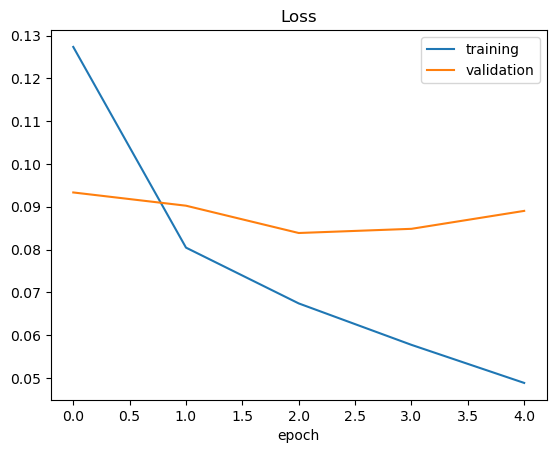

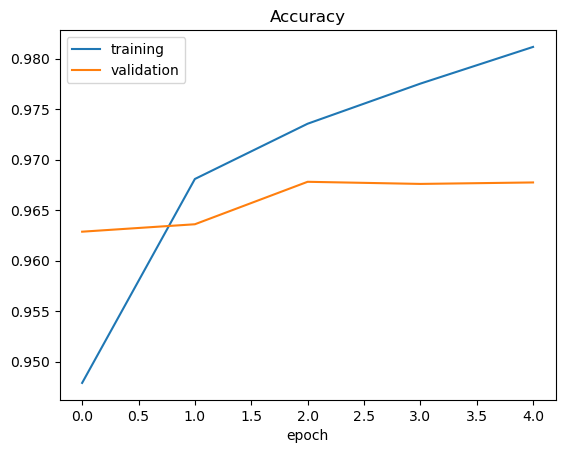

In [13]:
print(history.history['loss'])
print(history.history['val_loss'])
print(history.history['accuracy'])
print(history.history['val_accuracy'])

plt.figure(1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('epoch')


plt.figure(2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training', 'validation'])
plt.title('Accuracy')
plt.xlabel('epoch')

plt.show()

In [14]:
prd_df = pd.read_csv('C:/Users/outlul/Desktop/Πτυχιακη/Code/Datasets/LIAR_preprocessed_nolemma.csv')

In [15]:
val_text = prd_df['text']
val_label = prd_df['Label']

In [16]:
val_text_sequences = tokenizer.texts_to_sequences(val_text)

val_text_padded = pad_sequences(val_text_sequences, maxlen=sent_len)

In [17]:
test2_loss, test2_accuracy = model.evaluate(val_text_padded, val_label)

250/250 [==============================] - 5s 18ms/step - loss: 1.2303 - accuracy: 0.5043


In [18]:
pred = model.predict(val_text_padded)

250/250 [==============================] - 5s 19ms/step


In [19]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, classification_report, ConfusionMatrixDisplay

In [20]:
binary_predictions = []

for i in pred:
    if i >= 0.5:
        binary_predictions.append(1)
    else:
        binary_predictions.append(0) 

Accuracy on testing set: 0.5043292759442841
Precision on testing set: 0.732630979498861
Recall on testing set: 0.4607808022922636


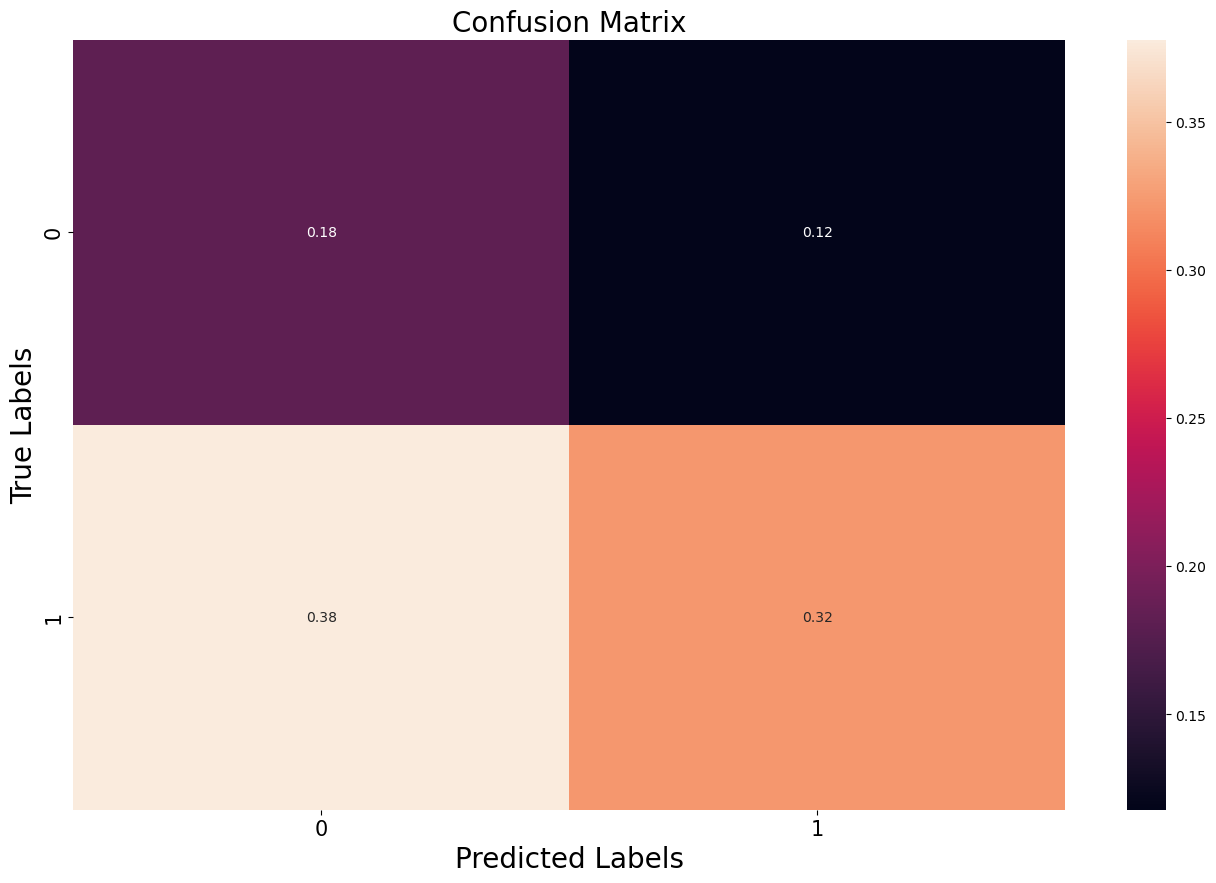

In [21]:
matrix = confusion_matrix(binary_predictions, val_label, normalize='all')
plt.figure(figsize=(16, 10))
ax= plt.subplot()
sns.heatmap(matrix, annot=True, ax = ax)

ax.set_xlabel('Predicted Labels', size=20)
ax.set_ylabel('True Labels', size=20)
ax.set_title('Confusion Matrix', size=20) 
ax.xaxis.set_ticklabels([0,1], size=15)
ax.yaxis.set_ticklabels([0,1], size=15)

print('Accuracy on testing set:', accuracy_score(binary_predictions, val_label))
print('Precision on testing set:', precision_score(binary_predictions, val_label))
print('Recall on testing set:', recall_score(binary_predictions, val_label))

In [22]:
print("Classification Report on LIAR set\n")
print(classification_report(binary_predictions, val_label))

Classification Report on LIAR set

              precision    recall  f1-score   support

           0       0.32      0.61      0.42      2385
           1       0.73      0.46      0.57      5584

    accuracy                           0.50      7969
   macro avg       0.53      0.53      0.49      7969
weighted avg       0.61      0.50      0.52      7969



6250/6250 [==============================] - 115s 18ms/step
Accuracy on testing set: 0.967795
Precision on testing set: 0.9627436823104694
Recall on testing set: 0.9656075224492524
Classification Report on Training set

              precision    recall  f1-score   support

           0       0.97      0.97      0.97    110242
           1       0.96      0.97      0.96     89758

    accuracy                           0.97    200000
   macro avg       0.97      0.97      0.97    200000
weighted avg       0.97      0.97      0.97    200000



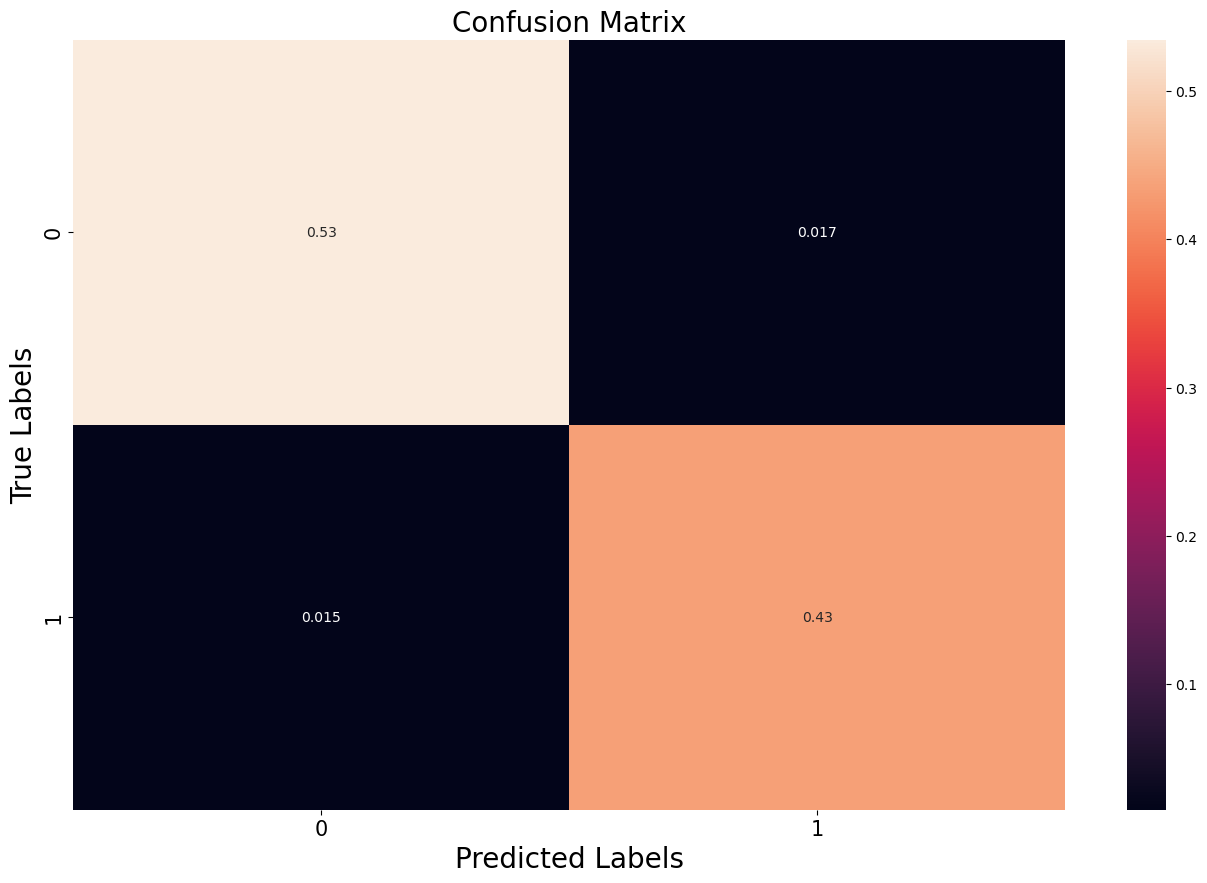

In [23]:
pred = model.predict(X_test_padded)

binary_predictions_Train = []

for i in pred:
    if i >= 0.5:
        binary_predictions_Train.append(1)
    else:
        binary_predictions_Train.append(0) 
        
matrix = confusion_matrix(binary_predictions_Train, y_test, normalize='all')
plt.figure(figsize=(16, 10))
ax= plt.subplot()
sns.heatmap(matrix, annot=True, ax = ax)

ax.set_xlabel('Predicted Labels', size=20)
ax.set_ylabel('True Labels', size=20)
ax.set_title('Confusion Matrix', size=20) 
ax.xaxis.set_ticklabels([0,1], size=15)
ax.yaxis.set_ticklabels([0,1], size=15)

print('Accuracy on testing set:', accuracy_score(binary_predictions_Train, y_test))
print('Precision on testing set:', precision_score(binary_predictions_Train, y_test))
print('Recall on testing set:', recall_score(binary_predictions_Train, y_test))

print("Classification Report on Training set\n")
print(classification_report(binary_predictions_Train, y_test))

2255/2255 [==============================] - 75s 33ms/step
Accuracy on testing set: 0.7811572905980536
Precision on testing set: 0.7177814908640112
Recall on testing set: 0.8336672092149743
Classification Report on WELFake set

              precision    recall  f1-score   support

           0       0.85      0.74      0.79     40186
           1       0.72      0.83      0.77     31948

    accuracy                           0.78     72134
   macro avg       0.78      0.79      0.78     72134
weighted avg       0.79      0.78      0.78     72134



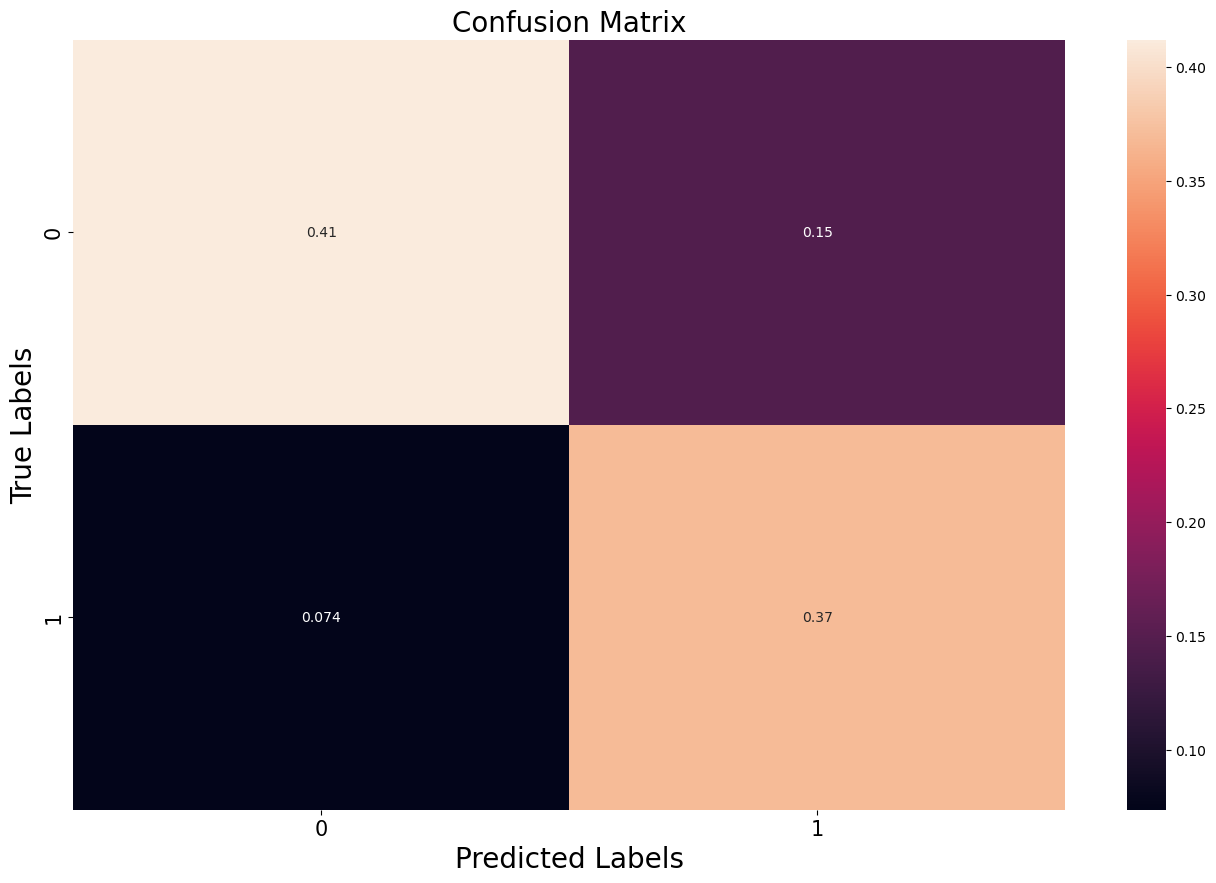

In [24]:
liar_df = pd.read_csv('C:/Users/outlul/Desktop/Πτυχιακη/Code/Datasets/WELFake_Dataset.csv')
liar_df.text = liar_df.text.astype(str)

liar_text = liar_df['text']
liar_label = liar_df['label']

liar_text_sequences = tokenizer.texts_to_sequences(liar_text)

liar_text_padded = pad_sequences(liar_text_sequences, maxlen=256)

pred_liar = model.predict(liar_text_padded)

binary_predictions_liar = []

for i in pred_liar:
    if i >= 0.5:
        binary_predictions_liar.append(1)
    else:
        binary_predictions_liar.append(0) 
        
matrix = confusion_matrix(binary_predictions_liar, liar_label, normalize='all')
plt.figure(figsize=(16, 10))
ax= plt.subplot()
sns.heatmap(matrix, annot=True, ax = ax)

ax.set_xlabel('Predicted Labels', size=20)
ax.set_ylabel('True Labels', size=20)
ax.set_title('Confusion Matrix', size=20) 
ax.xaxis.set_ticklabels([0,1], size=15)
ax.yaxis.set_ticklabels([0,1], size=15)

print('Accuracy on testing set:', accuracy_score(binary_predictions_liar, liar_label))
print('Precision on testing set:', precision_score(binary_predictions_liar, liar_label))
print('Recall on testing set:', recall_score(binary_predictions_liar, liar_label))

print("Classification Report on WELFake set\n")
print(classification_report(binary_predictions_liar, liar_label))

In [ ]:
import joblib

filename = "LSTM_Corpus_model_GloveEmbed.joblib"
joblib.dump(model, filename)